In [94]:
import twstock
import pandas as pd
from twstock import analytics
import matplotlib.pyplot as plt
import numpy as np
import mplfinance as mf
import matplotlib

In [104]:
STOCK_CODE = '2330'
stock = twstock.Stock(STOCK_CODE)
print(stock.sid)
data = stock.fetch_from(2014, 5)
print(data)

2330
[Data(date=datetime.datetime(2014, 5, 2, 0, 0), capacity=45030119, turnover=5324516642, open=119.0, high=119.5, low=117.0, close=118.0, change=-0.5, transaction=9573), Data(date=datetime.datetime(2014, 5, 5, 0, 0), capacity=28887828, turnover=3374584476, open=117.5, high=118.0, low=116.0, close=117.0, change=-1.0, transaction=8961), Data(date=datetime.datetime(2014, 5, 6, 0, 0), capacity=27525257, turnover=3247099826, open=117.0, high=119.0, low=116.5, close=118.0, change=1.0, transaction=5217), Data(date=datetime.datetime(2014, 5, 7, 0, 0), capacity=33276563, turnover=3931216686, open=118.0, high=119.0, low=117.5, close=118.5, change=0.5, transaction=6945), Data(date=datetime.datetime(2014, 5, 8, 0, 0), capacity=30096125, turnover=3594265403, open=119.5, high=120.0, low=119.0, close=119.5, change=1.0, transaction=5599), Data(date=datetime.datetime(2014, 5, 9, 0, 0), capacity=23287585, turnover=2785144700, open=120.0, high=120.0, low=119.0, close=120.0, change=0.5, transaction=640

In [105]:
name_attribute = ['Date', 'Capacity', 'Turnover', 'Open', 'High', 'Low', 'Close', 'Change', 'Transaction']
df = pd.DataFrame(columns= name_attribute, data = data,)
df.set_index(df.columns[0], inplace=True)
df.to_csv('date.csv')

In [106]:
weekly_price = df.resample('W-FRI').agg(
	{'Open'  :'first',
     'High'  :'max',
     'Low'   :'min',
     'Close' :'last',
    })
weekly_price = weekly_price.dropna()

In [107]:
UP = 1
DOWN = 0
GAP = 0
FALL = 0
SURGE = 1
BUY = 1
SELL = 0
ROUND = 3
DIFF = 0.95

In [108]:
weekly_price['MA5'] = weekly_price['Close'].rolling(5).mean().round(ROUND)
weekly_price['MA20'] = weekly_price['Close'].rolling(20).mean().round(ROUND)
weekly_price['diff'] = weekly_price['MA20'].diff().round(ROUND)
weekly_price = weekly_price.dropna()
weekly_price.to_csv('week.csv')

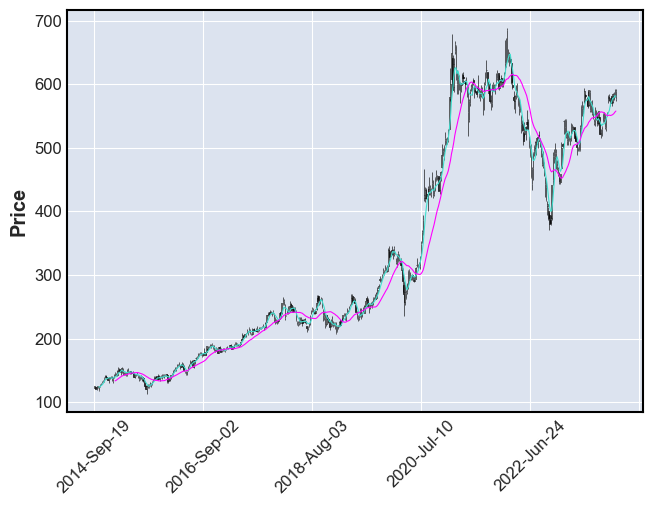

In [109]:
mf.plot(weekly_price, type='candle', mav=(5, 20))

In [110]:
weekly_price.loc[weekly_price['diff'] < 0 , ['20WK']] = DOWN
weekly_price.loc[weekly_price['diff'] > 0 , ['20WK']] = UP

weekly_price['gap'] = 1
jump_condition = weekly_price['High'].le(weekly_price['Low'].shift(1))
weekly_price.loc[jump_condition, 'gap'] = GAP

fall_condition = weekly_price['Close'].le(weekly_price['MA5'] * DIFF)
weekly_price.loc[fall_condition, '5WK'] = FALL

surge_condition = weekly_price['Close'].gt(weekly_price['MA5'])
weekly_price.loc[surge_condition, '5WK'] = SURGE

In [111]:
holding_stock = 0
accumulated_ratio = 1
linear_ratio = 0

for date, row in weekly_price.iterrows():
	if holding_stock:
		if (a:=(row['20WK'] == DOWN)) or (b:=(row['5WK'] == FALL)) or (c:=(row['gap'] == GAP)):
			current_price = row['Close']

			price_difference = current_price - holding_stock
			ratio_difference = current_price / holding_stock
			accumulated_ratio *= ratio_difference
			linear_ratio += ratio_difference - 1
			holding_stock = 0

			print(date, 'Sell', row['Close'], '因為: {}{}{} 損益: {} %'.format('20週線向下' if a else '',
																			  ' 跌破5週線' if b else '',
																			  ' 跳空' if c else '',
																			  round(((ratio_difference - 1) * 100), 2)))
	else:
		if row['20WK'] == UP and row['5WK'] == SURGE:
			current_price = row['Close']
			holding_stock = current_price
			print(date, 'buy', current_price)


print(f'總投報率(本利再投): {round((accumulated_ratio - 1) * 100, 2)} %')
print(f'總投報率(固定本金): {round((linear_ratio * 100), 2)} %')


2014-09-19 00:00:00 buy 125.0
2015-06-19 00:00:00 Sell 142.0 因為: 20週線向下 損益: 13.6 %
2015-06-26 00:00:00 buy 146.0
2015-07-03 00:00:00 Sell 142.5 因為: 20週線向下 損益: -2.4 %
2015-11-27 00:00:00 buy 139.0
2016-05-06 00:00:00 Sell 148.0 因為:  跳空 損益: 6.47 %
2016-05-27 00:00:00 buy 156.5
2017-02-10 00:00:00 Sell 185.5 因為: 20週線向下 損益: 18.53 %
2017-02-17 00:00:00 buy 189.5
2017-03-03 00:00:00 Sell 184.0 因為: 20週線向下 損益: -2.9 %
2017-03-17 00:00:00 buy 191.5
2018-02-09 00:00:00 Sell 232.5 因為:  跌破5週線 損益: 21.41 %
2018-03-09 00:00:00 buy 250.5
2018-04-20 00:00:00 Sell 229.0 因為: 20週線向下 損益: -8.58 %
2018-05-11 00:00:00 buy 233.0
2018-05-18 00:00:00 Sell 223.5 因為: 20週線向下 損益: -4.08 %
2018-08-31 00:00:00 buy 256.0
2018-10-12 00:00:00 Sell 237.0 因為:  跌破5週線 損益: -7.42 %
2018-11-02 00:00:00 buy 236.5
2018-12-07 00:00:00 Sell 221.0 因為: 20週線向下 損益: -6.55 %
2019-03-15 00:00:00 buy 239.0
2019-05-17 00:00:00 Sell 241.5 因為:  跌破5週線 損益: 1.05 %
2019-06-14 00:00:00 buy 236.0
2019-09-06 00:00:00 Sell 263.5 因為: 20週線向下 損益: 11.65 %


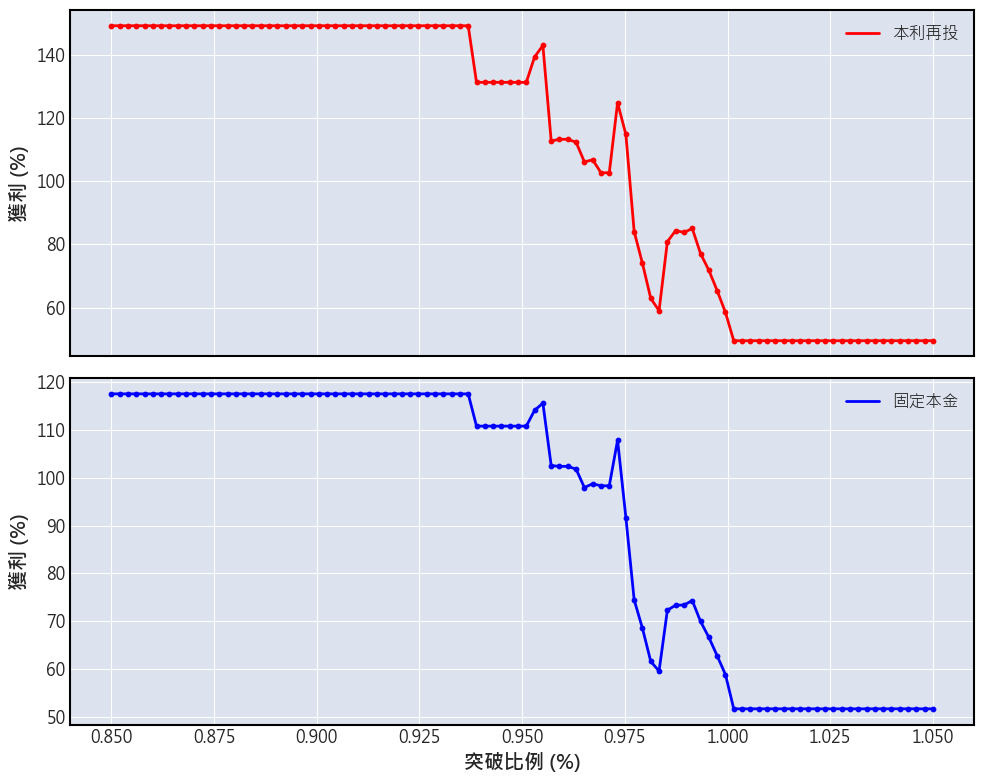

In [112]:
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei')
steps = np.linspace(0.85, 1.05, 100)
x = np.array([])
y = np.array([])
z = np.array([])
for DIFF in steps:
	weekly_price = pd.read_csv('week.csv')
	weekly_price.loc[weekly_price['diff'] < 0 , ['20WK']] = DOWN
	weekly_price.loc[weekly_price['diff'] > 0 , ['20WK']] = UP

	weekly_price['gap'] = 1
	jump_condition = weekly_price['High'].le(weekly_price['Low'].shift(1))
	weekly_price.loc[jump_condition, 'gap'] = GAP

	fall_condition = weekly_price['Close'].le(weekly_price['MA5'] * DIFF)
	weekly_price.loc[fall_condition, '5WK'] = FALL

	surge_condition = weekly_price['Close'].gt(weekly_price['MA5'])
	weekly_price.loc[surge_condition, '5WK'] = SURGE
	
	holding_stock = 0
	accumulated_ratio = 1
	linear_ratio = 0

	for date, row in weekly_price.iterrows():
		if holding_stock:
			if (a:=(row['20WK'] == DOWN)) or (b:=(row['5WK'] == FALL)) or (c:=(row['gap'] == GAP)):
				current_price = row['Close']

				price_difference = current_price - holding_stock
				ratio_difference = current_price / holding_stock
				accumulated_ratio *= ratio_difference
				linear_ratio += ratio_difference - 1
				holding_stock = 0

		else:
			if row['20WK'] == UP and row['5WK'] == SURGE:
				current_price = row['Close']
				holding_stock = current_price

	x = np.append(x, DIFF)
	y = np.append(y, (accumulated_ratio - 1) * 100)
	z = np.append(z, (linear_ratio * 100))


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(x, y, label='本利再投', color='red')
ax2.plot(x, z, label='固定本金', color='blue')

ax1.scatter(x, y, color='red', marker='o', s=10)
ax2.scatter(x, z, color='blue', marker='o', s=10)

ax1.set_ylabel('獲利 (%)')
ax2.set_ylabel('獲利 (%)')
ax2.set_xlabel('突破比例 (%)')
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()